## A complete example of ps-matching code

We first read the data and quickly explore it using tableone package

In [6]:
import pandas as pd
from tableone import TableOne
from typing import List

from pandas import Series
from src.plots import ScorePlotter
from src.prepare_data import PrepData
from src.propensity_matching import PScorer
from src.find_similarities import ObsMatcher

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [7]:
df = pd.read_csv('data/df.csv', index_col='id')
df.head()

,target,acquirer,order_total_spent,credit_card_type,credit_card_company,model_score_category
id,,,,,,
166518,1,acquirer_A,246,DEBIT,company_2,intermediate_score
132508,1,acquirer_B,198,CREDIT,company_1,intermediate_score
137852,0,acquirer_A,49,DEBIT,company_2,low_score
255871,1,acquirer_A,139,CREDIT,company_2,intermediate_score
229889,1,acquirer_A,111,DEBIT,company_1,intermediate_score


In [8]:
# Columns to summarize
columns = ['order_total_spent', 'credit_card_type', 'credit_card_company',
           'model_score_category', 'target']

# Columns containing categorical variables
categorical = ['credit_card_type', 'credit_card_company', 'model_score_category', 'target']

# Stratification variable - The Intervention
groupby = ['acquirer']

# Rename columns
labels={'order_total_spent': 'Total Spent', 'target': 'authorization'}

# Keep level 1 in target column
limit = {"target": 1}

table1 = TableOne(df, columns, categorical, groupby, pval=False, smd=True,
                  htest_name=True, limit=limit, rename=labels)
table1

Grouped by acquirer                                                                      
                                                           Missing       Overall    acquirer_A    acquirer_B SMD (acquirer_A,acquirer_B)
n                                                                          49995         38708         11287                            
Total Spent, mean (SD)                                           0  131.8 (63.7)  128.4 (63.9)  143.6 (61.5)                       0.242
credit_card_type, n (%)     CREDIT                               0  22998 (46.0)  16743 (43.3)   6255 (55.4)                       0.245
                            DEBIT                                   26997 (54.0)  21965 (56.7)   5032 (44.6)                            
credit_card_company, n (%)  company_1                            0  28435 (56.9)  24081 (62.2)   4354 (38.6)                       0.487
                            company_2                               21560 (43.1)  14627 (37.8)   6933 (61.4)                            
model_score_category, n (%) high_score                           0  12586 (25.2)  10725 (27.7)   1861 (16.5)                       0.385
                            intermediate_score                      24909 (49.8)  19658 (50.8)   5251 (46.5)                            
                            low_score                               12500 (25.0)   8325 (21.5)   4175 (37.0)                            
authorization, n (%)        1                                    0  41901 (83.8)  32957 (85.1)   8944 (79.2)                       0.155

Now we set the relevant variables and initiate the PrepData class

In [9]:
PS_GROUP = 'acquirer'     # set the group variable (treatment/control)
TARGET = 'target'         # set the target variable, the outcome of interest
FILE_PATH = 'data/df.csv' # dataframe contains all dependant and independent variables

In [10]:
data = PrepData(FILE_PATH, group=PS_GROUP, target=TARGET,  index_col="id")

loaded data with 49995 observations
False    0.774237
True     0.225763
Name: acquirer, dtype: float64
The minority class contains 11287 observations
False    0.838104
True     0.161896
Name: target, dtype: float64
The minority class contains 8094 observations


We initiate the PScorer and estimate the Propensity Score, currently only logostic regression is availble

In [12]:
scorer = PScorer()
scorer.fit(data.input, data.group_label)
ps_scores: Series = scorer.predict(data.input)
ps_scores

id
166518    0.350140
132508   -0.209982
137852    0.581685
255871    0.582715
229889   -0.783610
            ...   
137660   -0.869582
140041    1.225633
191360   -0.173064
247552   -0.829147
292476   -0.514117
Length: 49995, dtype: float64

Using ROC curve and AUC is a useful way to assess the model fit

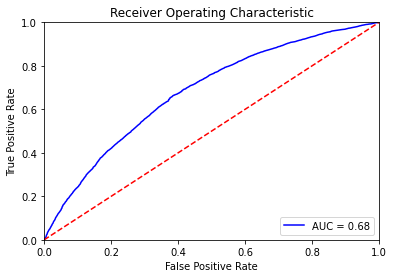

In [13]:
ScorePlotter.plot_roc_curve(ps_scores, data.group_label)

We initate the ObsMatcher class, set the matching ratio and the caliper

In [14]:
matcher = ObsMatcher(n_matches=1, caliper=0.001)
matched_index: List[int] = matcher.match_scores(ps_scores, data.group_label)

  0%|          | 28/11287 [00:00<00:41, 272.88it/s]

starting matching process, this might take a time


100%|██████████| 11287/11287 [00:24<00:00, 465.61it/s]

please note:the matched dataset contains 10659 observations from minority class


Using SMD plot, before and after matching, we can asses the matching quality

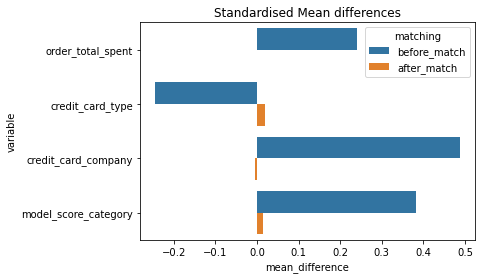

In [15]:
 ScorePlotter.plot_smd_comparison(
        data=data.input,
        matched_index=matched_index,
        treatment=data.group_label
        )

We now can run again the tableone and assess the causal effect on the matched population

In [20]:
df_matched = df[df.index.isin(matched_index)]
df_matched.acquirer.value_counts()

acquirer_A    10659
acquirer_B    10659
Name: acquirer, dtype: int64

In [21]:
table2 = TableOne(df_matched, columns, categorical, groupby, pval=False, smd=True,
                  htest_name=True, limit=limit, rename=labels)
table2

Grouped by acquirer                                                                      
                                                           Missing       Overall    acquirer_A    acquirer_B SMD (acquirer_A,acquirer_B)
n                                                                          21318         10659         10659                            
Total Spent, mean (SD)                                           0  141.0 (61.9)  141.1 (62.9)  141.0 (60.9)                      -0.001
credit_card_type, n (%)     CREDIT                               0  11775 (55.2)   5935 (55.7)   5840 (54.8)                       0.018
                            DEBIT                                    9543 (44.8)   4724 (44.3)   4819 (45.2)                            
credit_card_company, n (%)  company_1                            0   8574 (40.2)   4275 (40.1)   4299 (40.3)                       0.005
                            company_2                               12744 (59.8)   6384 (59.9)   6360 (59.7)                            
model_score_category, n (%) high_score                           0   3711 (17.4)   1855 (17.4)   1856 (17.4)                       0.023
                            intermediate_score                      10471 (49.1)   5291 (49.6)   5180 (48.6)                            
                            low_score                                7136 (33.5)   3513 (33.0)   3623 (34.0)                            
authorization, n (%)        1                                    0  17610 (82.6)   8965 (84.1)   8645 (81.1)                       0.079